# ATE Estimation for Count Data

This notebook is a continuation of the [previous notebook](https://juanitorduz.github.io/causal_inference_logistic/) on ATE estimation for binary data with logistic regression based on the sequence of (great!) posts by [Solomon Kurz](https://solomonkurz.netlify.app/). In this notebook, we will focus on count data. We reproduce in python an example presented in the post [Causal inference with count regression](https://solomonkurz.netlify.app/blog/2023-05-07-causal-inference-with-count-regression/) by Solomon Kurz. Our intention is to simply show how to port these type of model to [`bambi`](https://bambinos.github.io/bambi/). In addition, as in the previous post, we compare the ATE estimation with a simple linear regression model.

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "logistic"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


## Read Data

The data used in this example is the [`epilepsy`](https://github.com/paul-buerkner/brms/blob/master/data/epilepsy.rda) data set available in the [`bmrs`](https://paul-buerkner.github.io/brms/) package. From the package documentation:

> *Breslow and Clayton (1993) analyze data initially provided by Thall and Vail (1990) concerning seizure counts in a randomized trial of anti-convulsant therapy in epilepsy. Covariates are treatment, 8-week baseline seizure counts, and age of the patients in years.*

Solomon's blog give us more detail on the data set:
> *The original study was designed to see how well the anti-convulsant drug progabide reduced epileptic seizures in persons who experienced simple or complex partial seizures. After a baseline assessment, participants were randomized into treatment groups in which they received either progabide (`Trt` == 1) or a placebo (`Trt` == 0). The primary outcome variable in the data is count, which is the number of epileptic seizures each participant had had since their last visit. Following their baseline assessments, participants came back every two weeks for assessments, which are denoted by the factor variable `visit`.*

To reproduce the analysis we got the data from the [`bmrs`](https://paul-buerkner.github.io/brms/) package and save it in a csv file.

In [3]:
raw_df = pd.read_csv("../data/brms_epilepsy.csv")

df = raw_df.copy()
df.columns = df.columns.str.lower()

df.head()


,age,base,trt,patient,visit,count,obs,zage,zbase
0,31,11,0,1,1,5,1,0.424995,-0.757173
1,30,11,0,2,1,3,2,0.265284,-0.757173
2,25,6,0,3,1,2,3,-0.533274,-0.944403
3,36,8,0,4,1,4,4,1.223553,-0.869511
4,22,66,0,5,1,7,5,-1.012408,1.302363


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      236 non-null    int64  
 1   base     236 non-null    int64  
 2   trt      236 non-null    int64  
 3   patient  236 non-null    int64  
 4   visit    236 non-null    int64  
 5   count    236 non-null    int64  
 6   obs      236 non-null    int64  
 7   zage     236 non-null    float64
 8   zbase    236 non-null    float64
dtypes: float64(2), int64(7)
memory usage: 16.7 KB


Let's star by replicating one of the initial plots from the post where we see the count per visit for all the patients split by the treatment group.


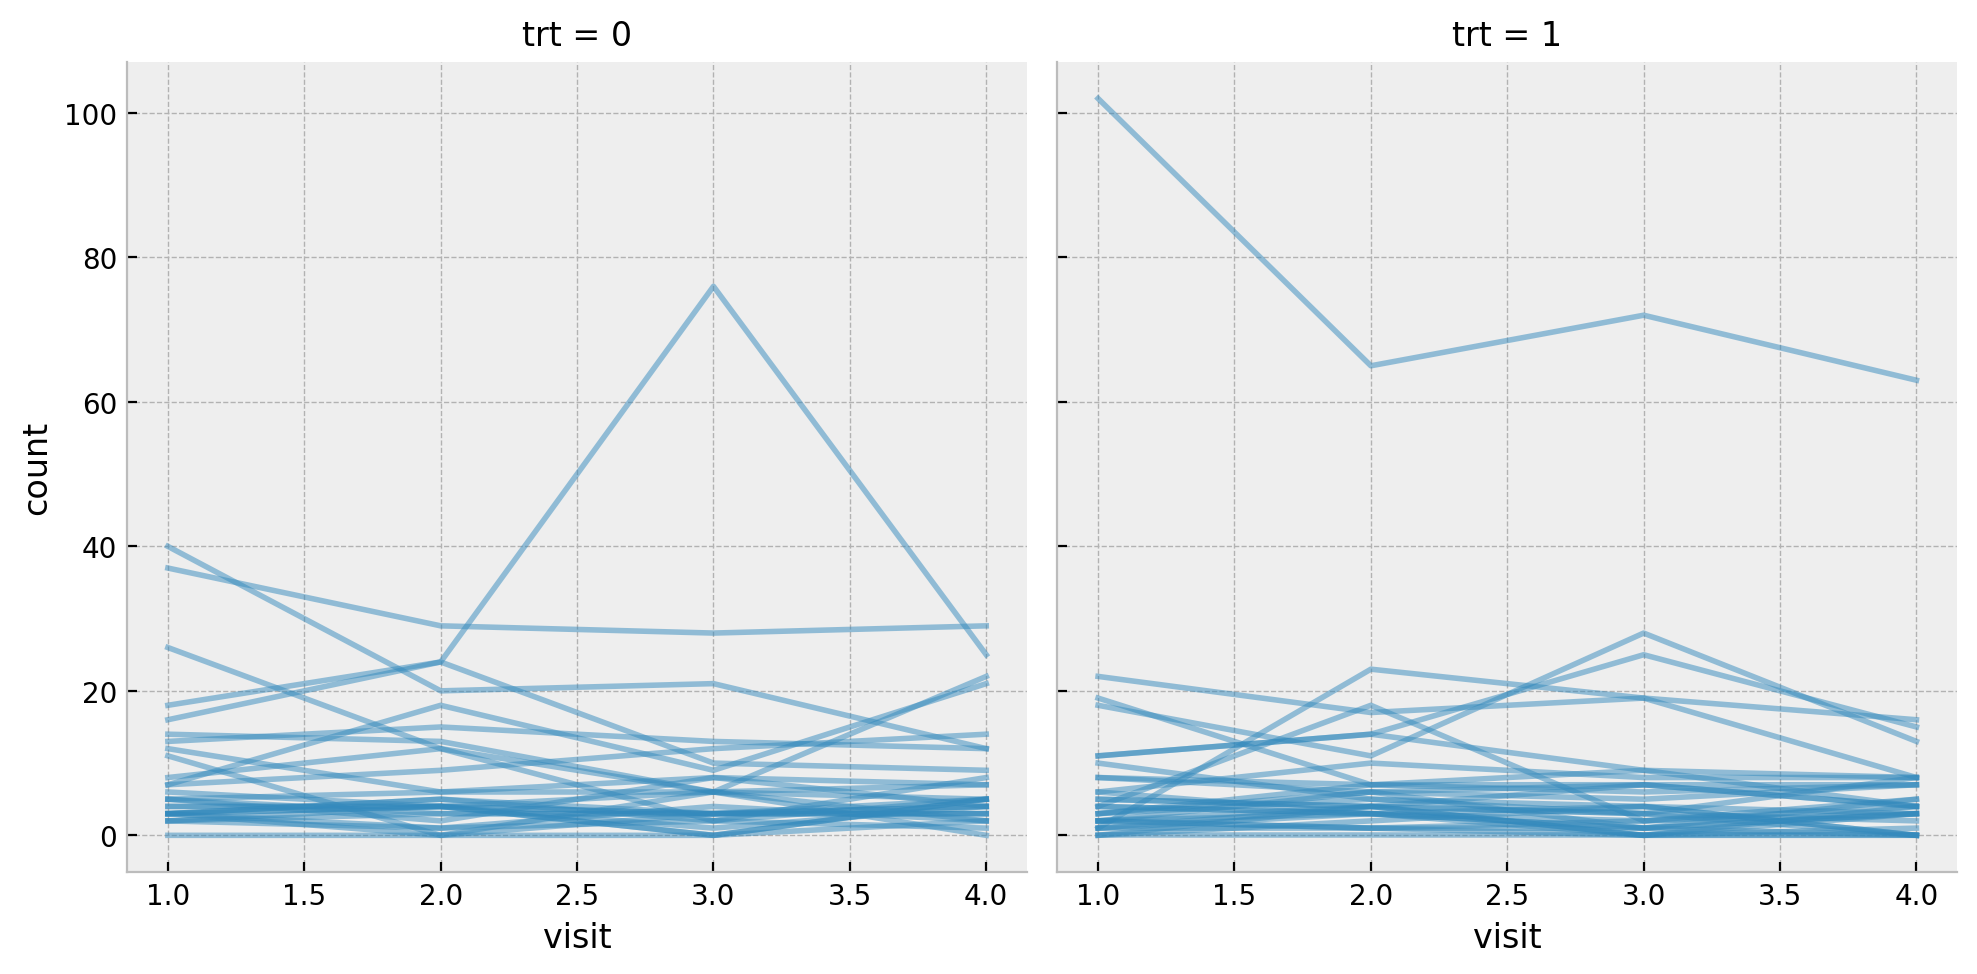

In [5]:
g = sns.relplot(
    data=df,
    x="visit",
    y="count",
    col="trt",
    kind="line",
    units="patient",
    estimator=None,
    color="C0",
    alpha=0.5,
)


Next we get some basic statistics about the target variable `count` split by the treatment group `trt` and the `visit`.

In [6]:
df.groupby(["trt", "visit"]).agg({"count": [np.mean, np.var, np.min, np.max]})

count                      
               mean         var amin amax
trt visit                                
0   1      9.357143  102.756614    0   40
    2      8.285714   66.656085    0   29
    3      8.714286  213.322751    0   76
    4      7.964286   58.183862    0   29
1   1      8.580645  332.718280    0  102
    2      8.419355  140.651613    0   65
    3      8.129032  193.049462    0   72
    4      6.709677  126.879570    0   63

## Data Preparation

Fot the sake of this analysis we filter out the last visit.

In [7]:
data = df.query("visit == 4").reset_index(drop=True)

data.head()


,age,base,trt,patient,visit,count,obs,zage,zbase
0,31,11,0,1,4,3,178,0.424995,-0.757173
1,30,11,0,2,4,3,179,0.265284,-0.757173
2,25,6,0,3,4,5,180,-0.533274,-0.944403
3,36,8,0,4,4,4,181,1.223553,-0.869511
4,22,66,0,5,4,21,182,-1.012408,1.302363


We can verify the number of participants in each group.

In [8]:
data.groupby("trt").agg({"patient": "nunique"})


,patient
trt,
0,28
1,31


## Difference in Means

As in the previous post, since this data set comes from a randomized controlled trial (RCT), we can use the difference in means (DIM) as a baseline for the ATE estimation.

In [9]:
diff_means = (
    data.query("trt == 1")["count"].mean() - data.query("trt == 0")["count"].mean()
)

print(f"Sample ATE: {diff_means:.3f}")


Sample ATE: -1.255


[Text(0.5, 1.0, 'Distribution of Counts by Treatment Group')]

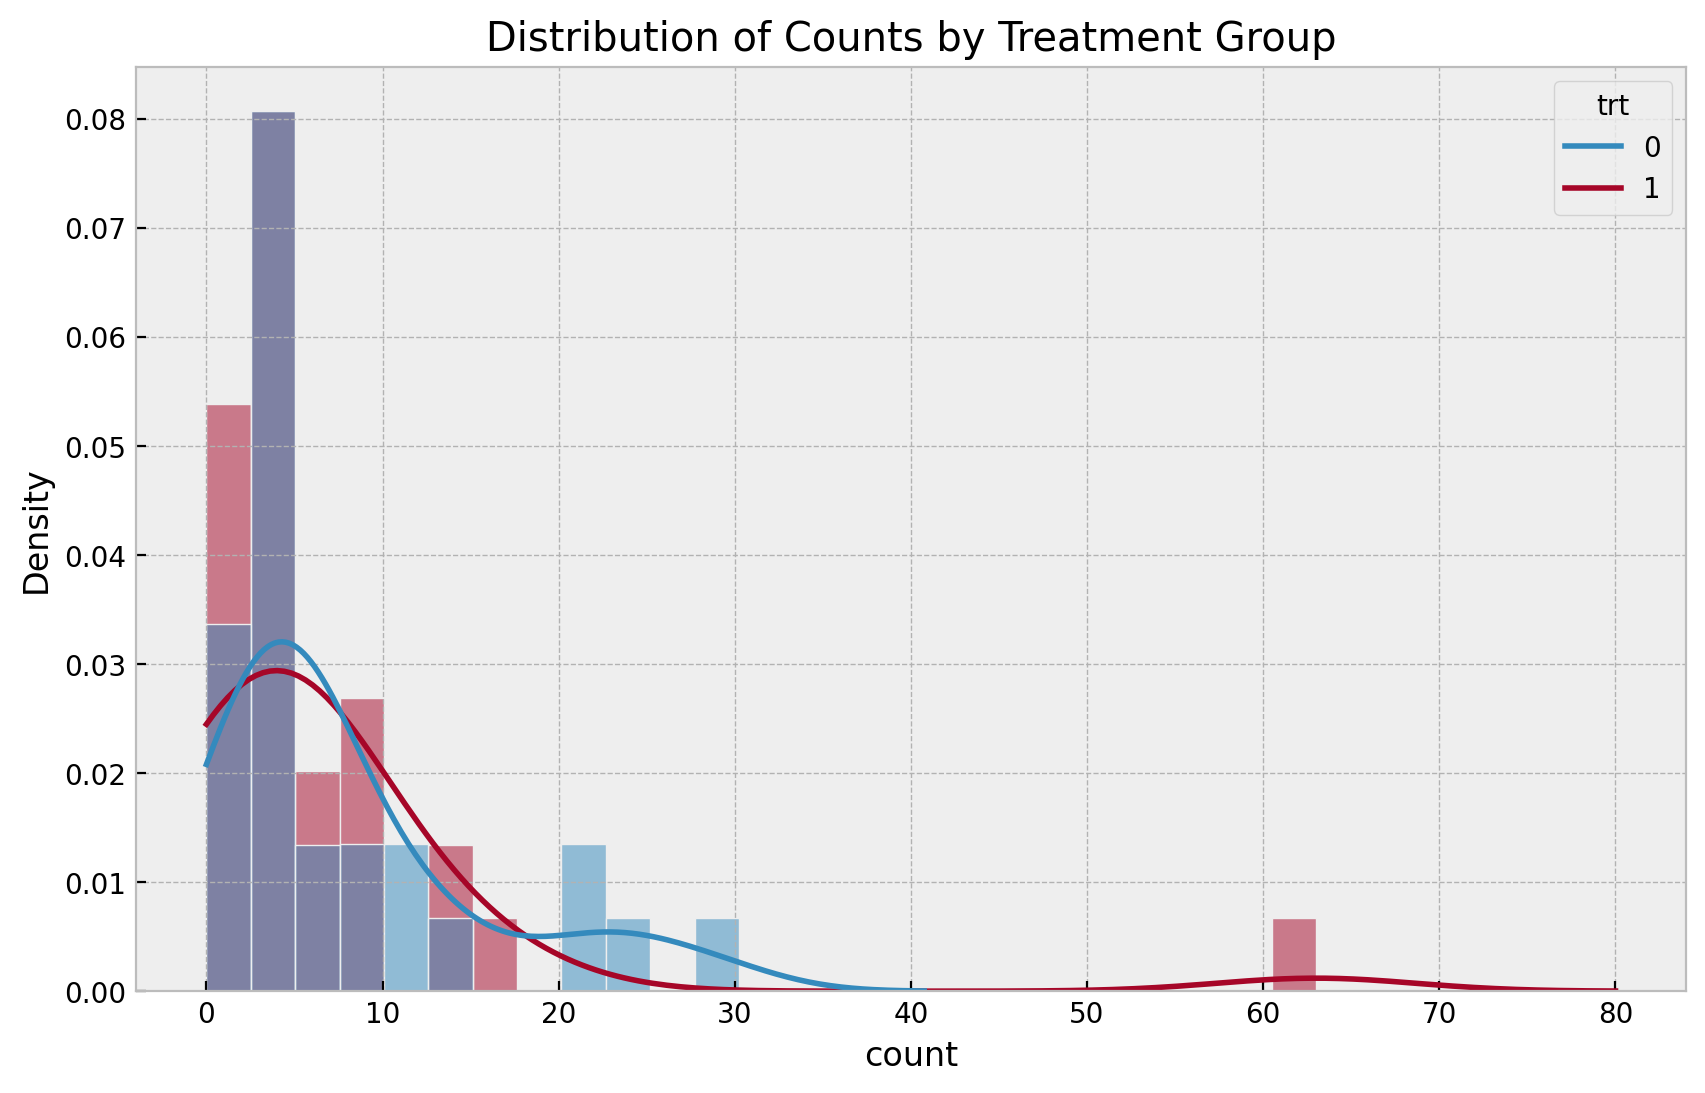

In [10]:
fig, ax = plt.subplots()
sns.histplot(data=data, x="count", hue="trt", stat="density", ax=ax)
sns.kdeplot(data=data, x="count", hue="trt", clip=(0, None), ax=ax)
ax.set(title="Distribution of Counts by Treatment Group")


We would like to estimate our uncertainty regarding this estimation.

## Negative Binomial Model

To model count data a natural likelihood function is the [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution). We could have used a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), but looking into the statistics above we expect some overdispersion in the data. 

We define our model in the same manner as in Solomon's post:

In [11]:
negative_binomial_priors = {
    "Intercept": bmb.Prior("Normal", mu=np.log(14), sigma=1),
    "trt": bmb.Prior("Normal", mu=0, sigma=0.5),
    "alpha": bmb.Prior("Gamma", alpha=0.01, beta=0.01),
}

negative_binomial_model = bmb.Model(
    formula="count ~ trt",
    data=data,
    family="negativebinomial",
    link="log",
    priors=negative_binomial_priors,
)

negative_binomial_model

       Formula: count ~ trt
        Family: negativebinomial
          Link: mu = log
  Observations: 59
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 2.6391, sigma: 1.0)
            trt ~ Normal(mu: 0.0, sigma: 0.5)
        
        Auxiliary parameters
            count_alpha ~ Gamma(alpha: 0.01, beta: 0.01)

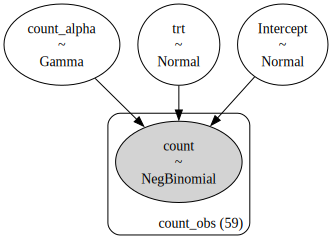

In [12]:
negative_binomial_model.build()
negative_binomial_model.graph()


Before fitting the model, let's take a look at the priors. One of the aspects I like the most about Solomon's blogs are the discussion about prior selection. In this case:

> *By centering the prior for (the intercept) $\beta_{0}$ on $\log(14)$, I’m betting those in the control (placebo) condition will report about $1$ seizure at day (i.e., $14$ during the last 2-week period). But since I know very little about seizures, and even less about seizure medication trials, I’m very insure about that prior, which is why I’ve set the prior standard deviation to $1$.*

Observe that we are using a $\log$ link function to make the mean of the negative binomial distribution positive. This explains the $\log$ transformation of the prior mean of intercept $\beta_{0}$.

In addition, 

> *The $\text{Gamma}(0.01,0.01)$ prior for $\alpha$ is the default in the `brms` package.*

For more tips and trick regarding prior specification for negative binomial models, please look into [this Stan guide](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#story-when-the-generic-prior-fails-the-case-of-the-negative-binomial).

Sampling: [Intercept, count_alpha, trt]
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 0.98, 'Negative Binomial Model Priors')

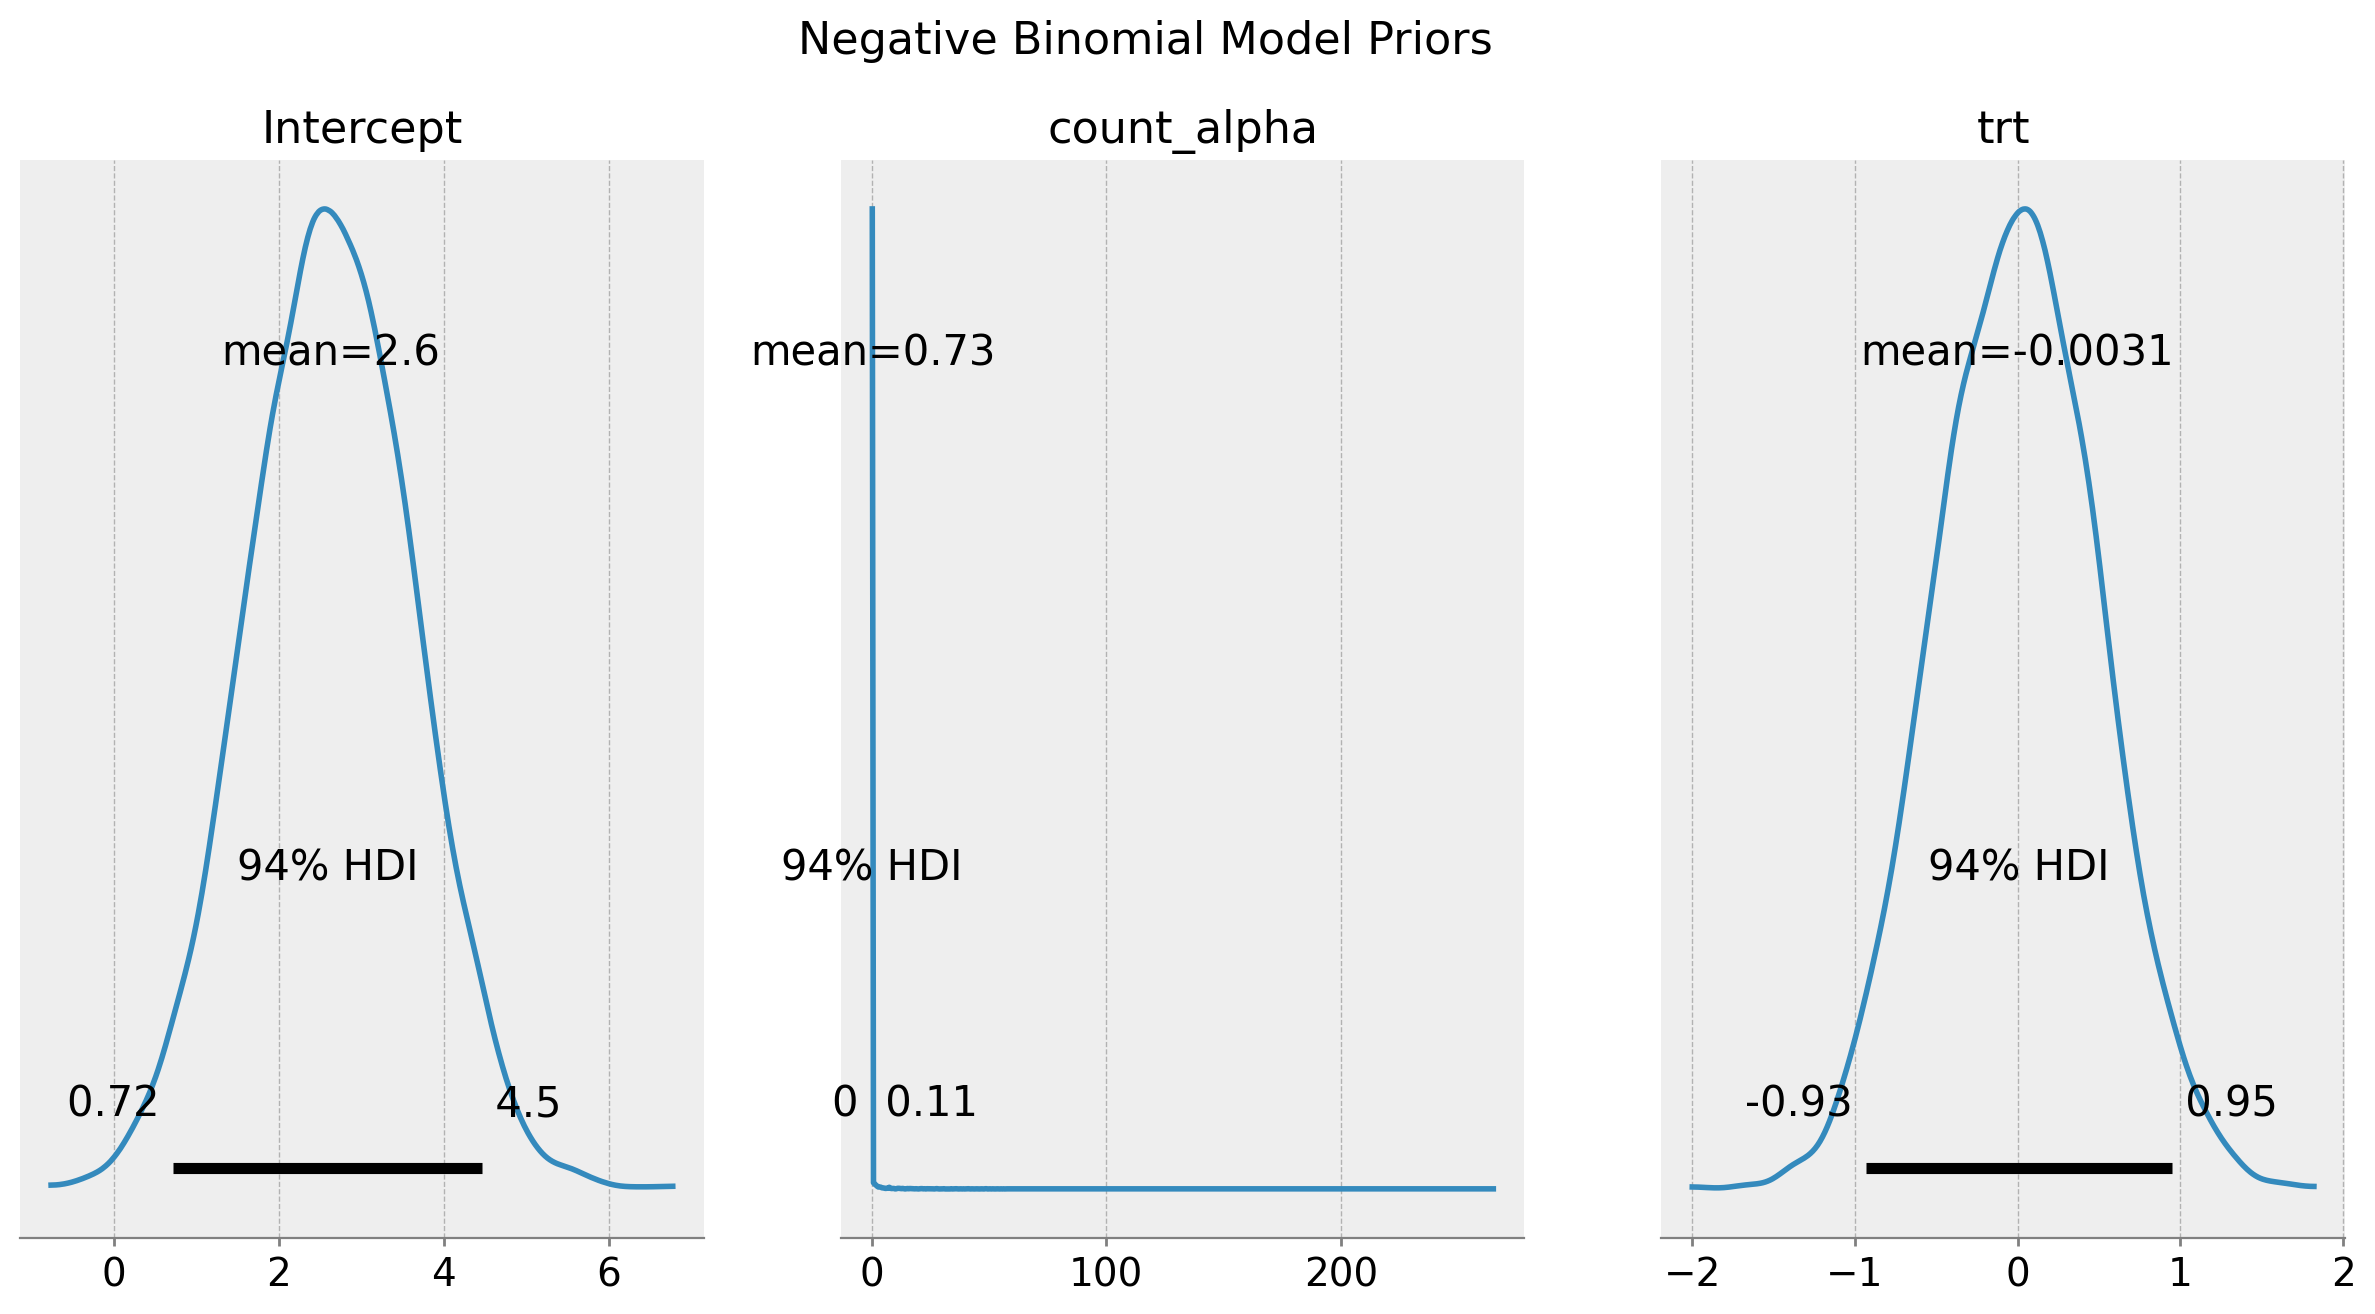

In [13]:
negative_binomial_model.plot_priors(draws=10_000, figsize=(15, 7), random_seed=rng)
plt.gcf().suptitle("Negative Binomial Model Priors", fontsize=16)


Now we proceed to fit the model:

In [14]:
negative_binomial_idata = negative_binomial_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

negative_binomial_model.predict(idata=negative_binomial_idata, kind="pps")


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.590414
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:04.426783
Transforming variables...
Transformation time =  0:00:00.027736


Next, we now look into the summary table and the trace plots:

In [15]:
az.summary(data=negative_binomial_idata, var_names=["Intercept", "trt", "count_alpha"])


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.079,0.190,1.732,2.446,0.001,0.001,19192.0,13083.0,1.0
trt,-0.132,0.246,-0.594,0.327,0.002,0.002,18391.0,14179.0,1.0
count_alpha,1.038,0.222,0.645,1.453,0.002,0.001,17646.0,15257.0,1.0


Text(0.5, 0.98, 'Negative Binomial Regression Model - Trace')

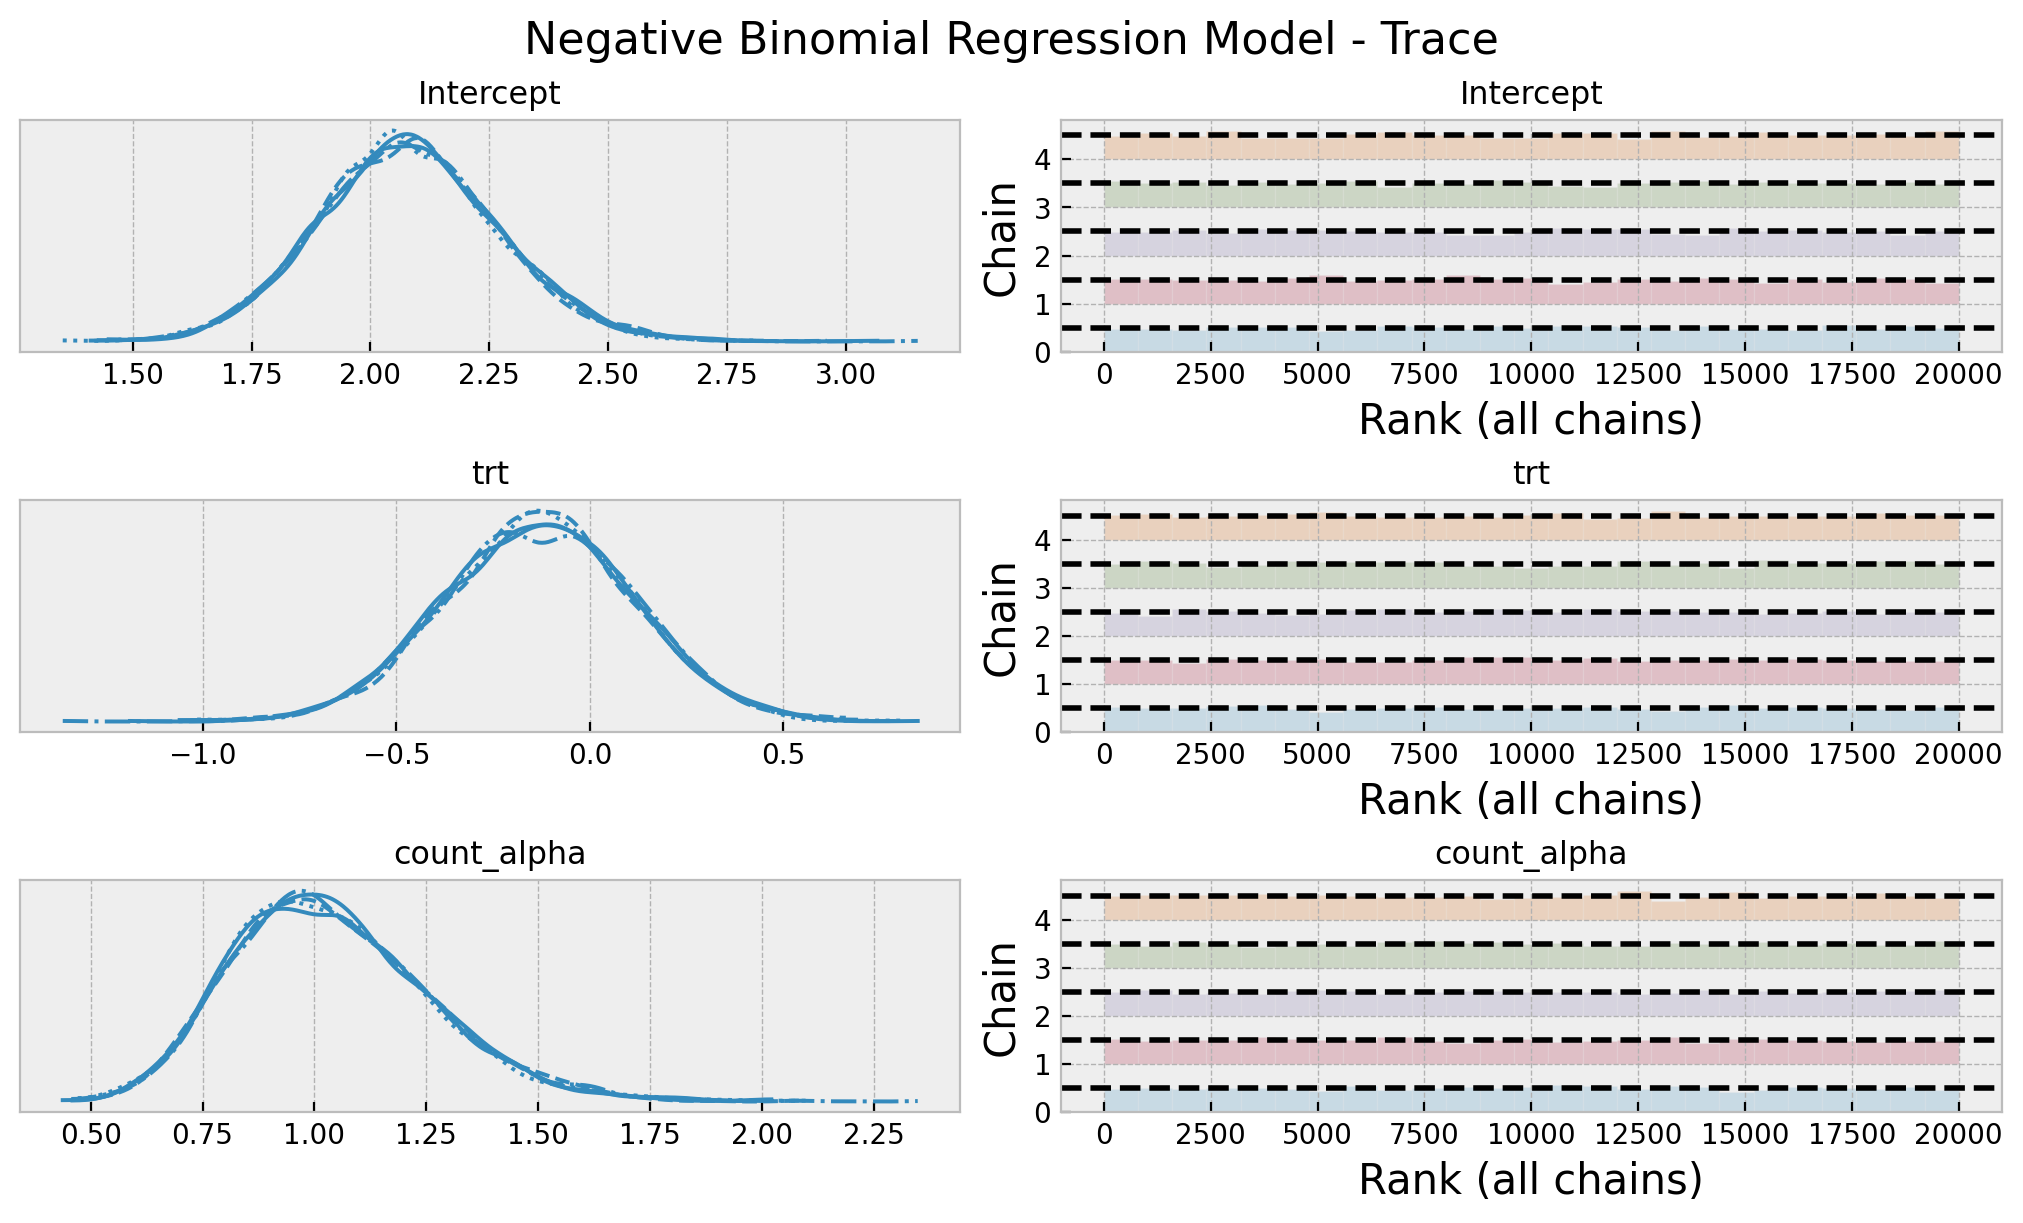

In [16]:
axes = az.plot_trace(
    data=negative_binomial_idata,
    var_names=["Intercept", "trt", "count_alpha"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Negative Binomial Regression Model - Trace", fontsize=16)


As in explained in the [previous post](https://juanitorduz.github.io/causal_inference_logistic/), to recover the ATE estimation we need to compute the difference between the posterior mean of the treatment group and the posterior mean of the control group taking the inverse of the link function into account. In this case we need to take the exponential. If we denote by $\beta_{0}$ the intercept and $\beta_1$ the coefficient of the treatment group variable `trt`, then the posterior mean of the treatment group is given by $\exp(\beta_{0} + \beta_{1})$ and the posterior mean of the control group is given by $\exp(\beta_{0})$. Therefore, the ATE estimation is given by 

$$\exp(\beta_{0} + \beta_{1}) - \exp(\beta_{1})$$

We can easily compute this from the trace:

[Text(0.5, 1.0, 'Negative Binomial Model - ATE'), Text(0.5, 0, 'ATE')]

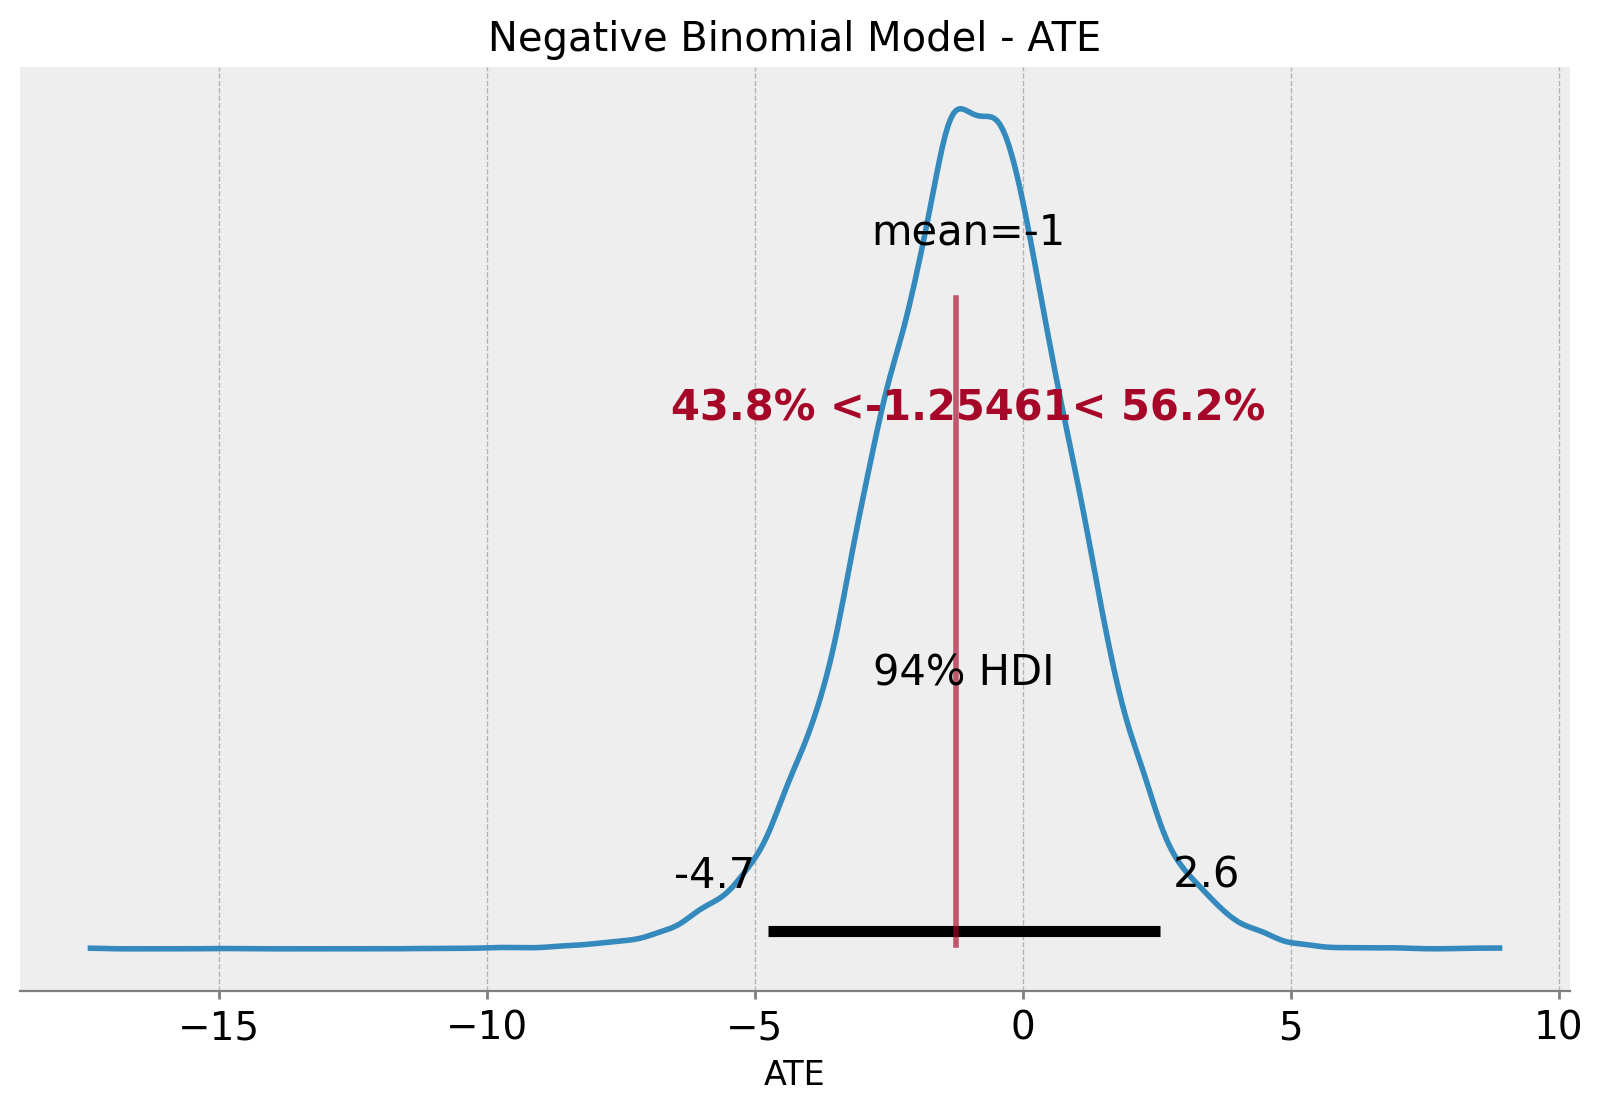

In [17]:
ate_samples = np.exp(
    negative_binomial_idata["posterior"]["Intercept"]
    + negative_binomial_idata["posterior"]["trt"]
) - np.exp(negative_binomial_idata["posterior"]["Intercept"])

fig, ax = plt.subplots()
az.plot_posterior(data=ate_samples, ref_val=diff_means, ax=ax)
ax.set(title="Negative Binomial Model - ATE", xlabel="ATE")

We see how the ATE posterior distribution is centered around the sample ATE computed from the difference in means.

## Linear Regression Model (OLS)

We now run a similar model but using a linear regression model with an identity link function.

In [18]:
gaussian_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=14, sigma=3),
    "trt": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("Exponential", lam=1 / 10),
}
gaussian_model = bmb.Model(
    formula="count ~ trt",
    data=data,
    family="gaussian",
    link="identity",
    priors=gaussian_model_priors,
)

gaussian_model

       Formula: count ~ trt
        Family: gaussian
          Link: mu = identity
  Observations: 59
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 14.0, sigma: 3.0)
            trt ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            count_sigma ~ Exponential(lam: 0.1)

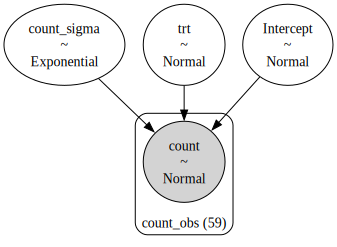

In [19]:
gaussian_model.build()
gaussian_model.graph()


We fit the model and look into the results and diagnostics.

In [20]:
gaussian_idata = gaussian_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

gaussian_model.predict(idata=gaussian_idata, kind="pps")


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.353726
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:03.436073
Transforming variables...
Transformation time =  0:00:00.011796


In [21]:
az.summary(data=gaussian_idata, var_names=["Intercept", "trt", "count_sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,8.877,1.693,5.712,12.051,0.012,0.009,18427.0,13652.0,1.0
trt,-0.999,2.265,-5.148,3.367,0.017,0.015,18344.0,14465.0,1.0
count_sigma,9.879,0.943,8.165,11.662,0.007,0.005,18528.0,14232.0,1.0


Text(0.5, 0.98, 'Linear Regression Model - Trace')

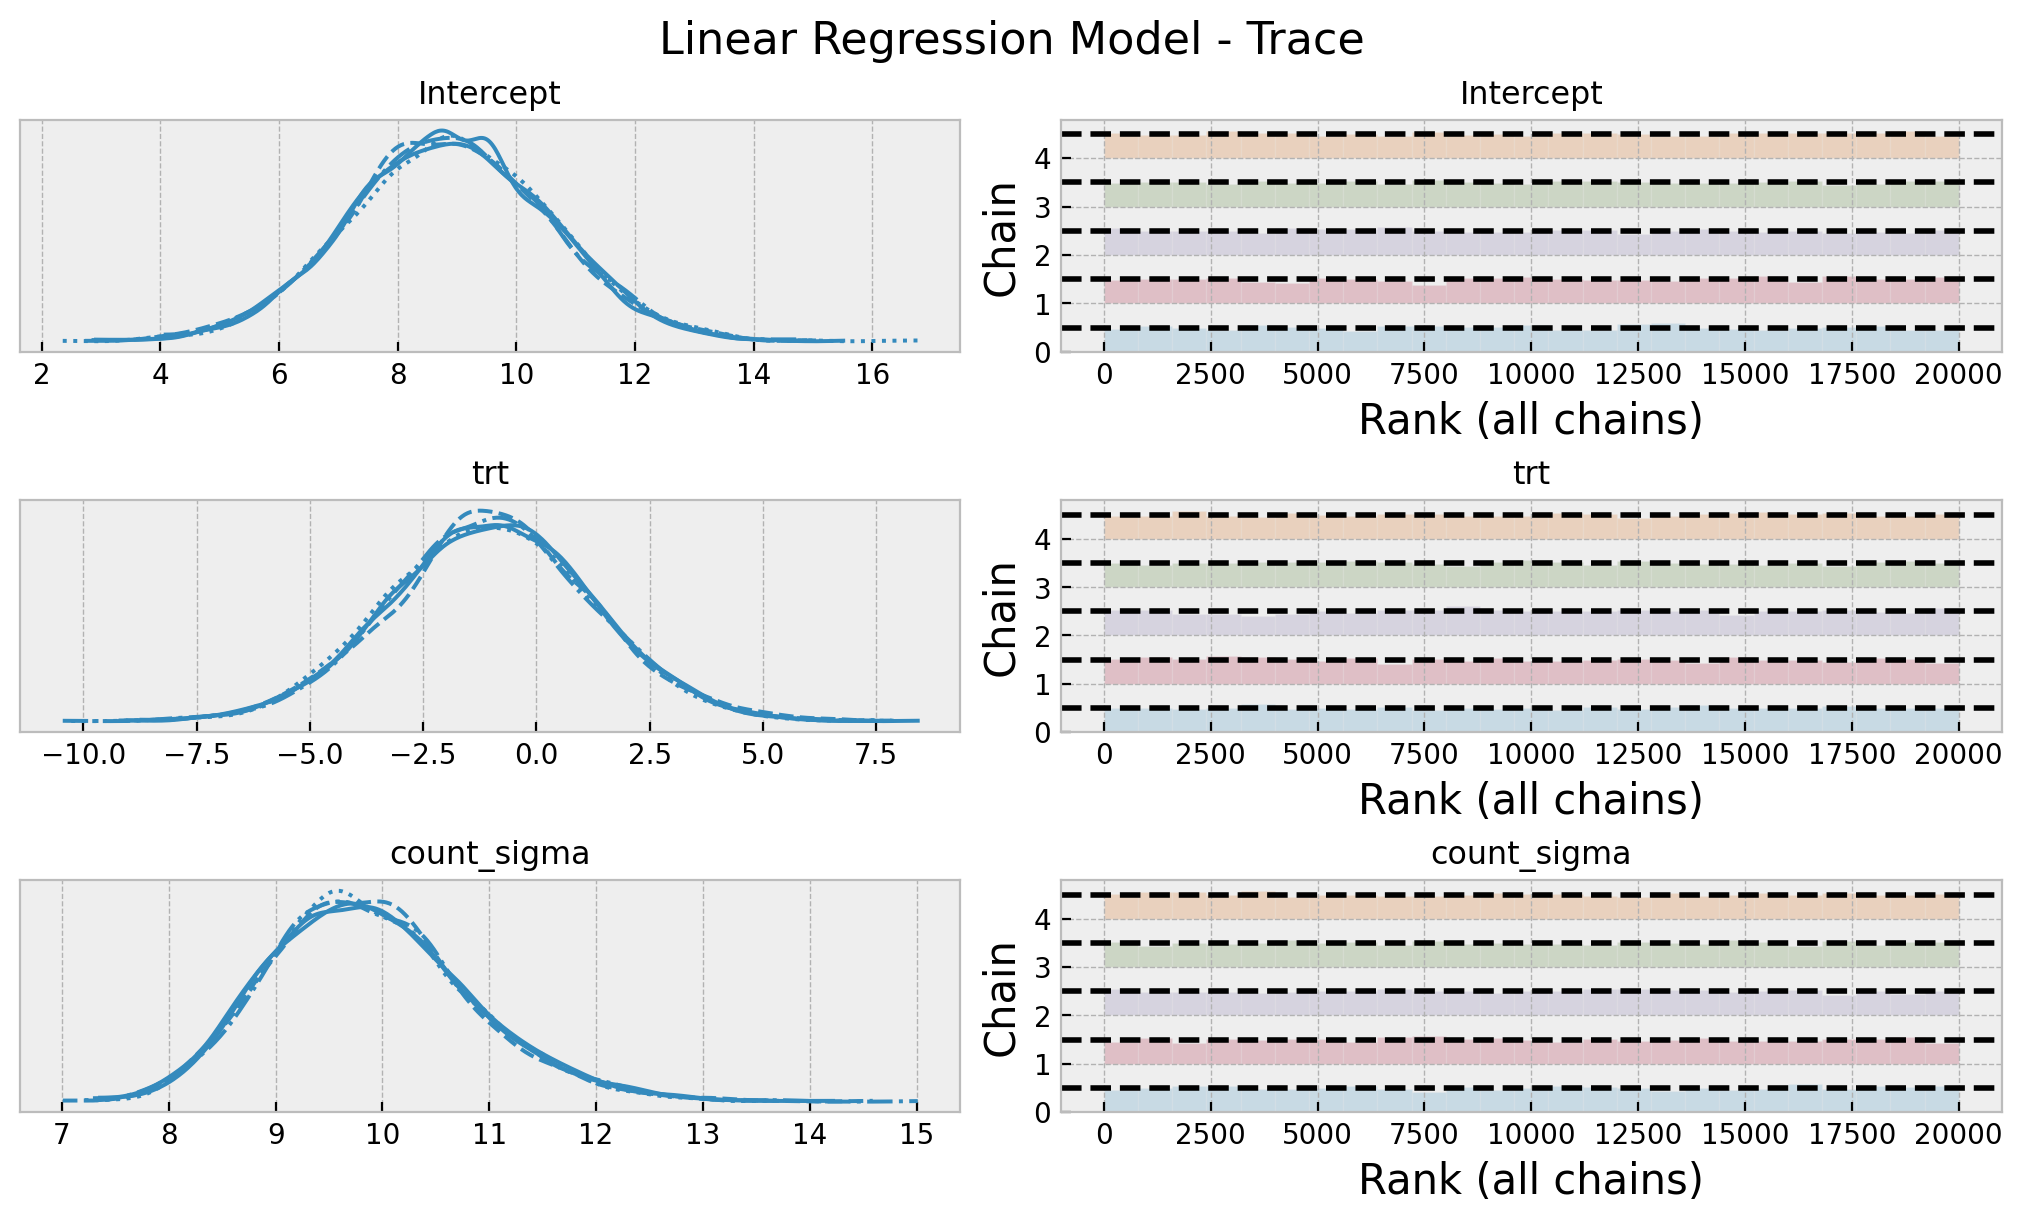

In [22]:
axes = az.plot_trace(
    data=gaussian_idata,
    var_names=["Intercept", "trt", "count_sigma"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Regression Model - Trace", fontsize=16)


Text(0.5, 1.05, 'ATE Comparison')

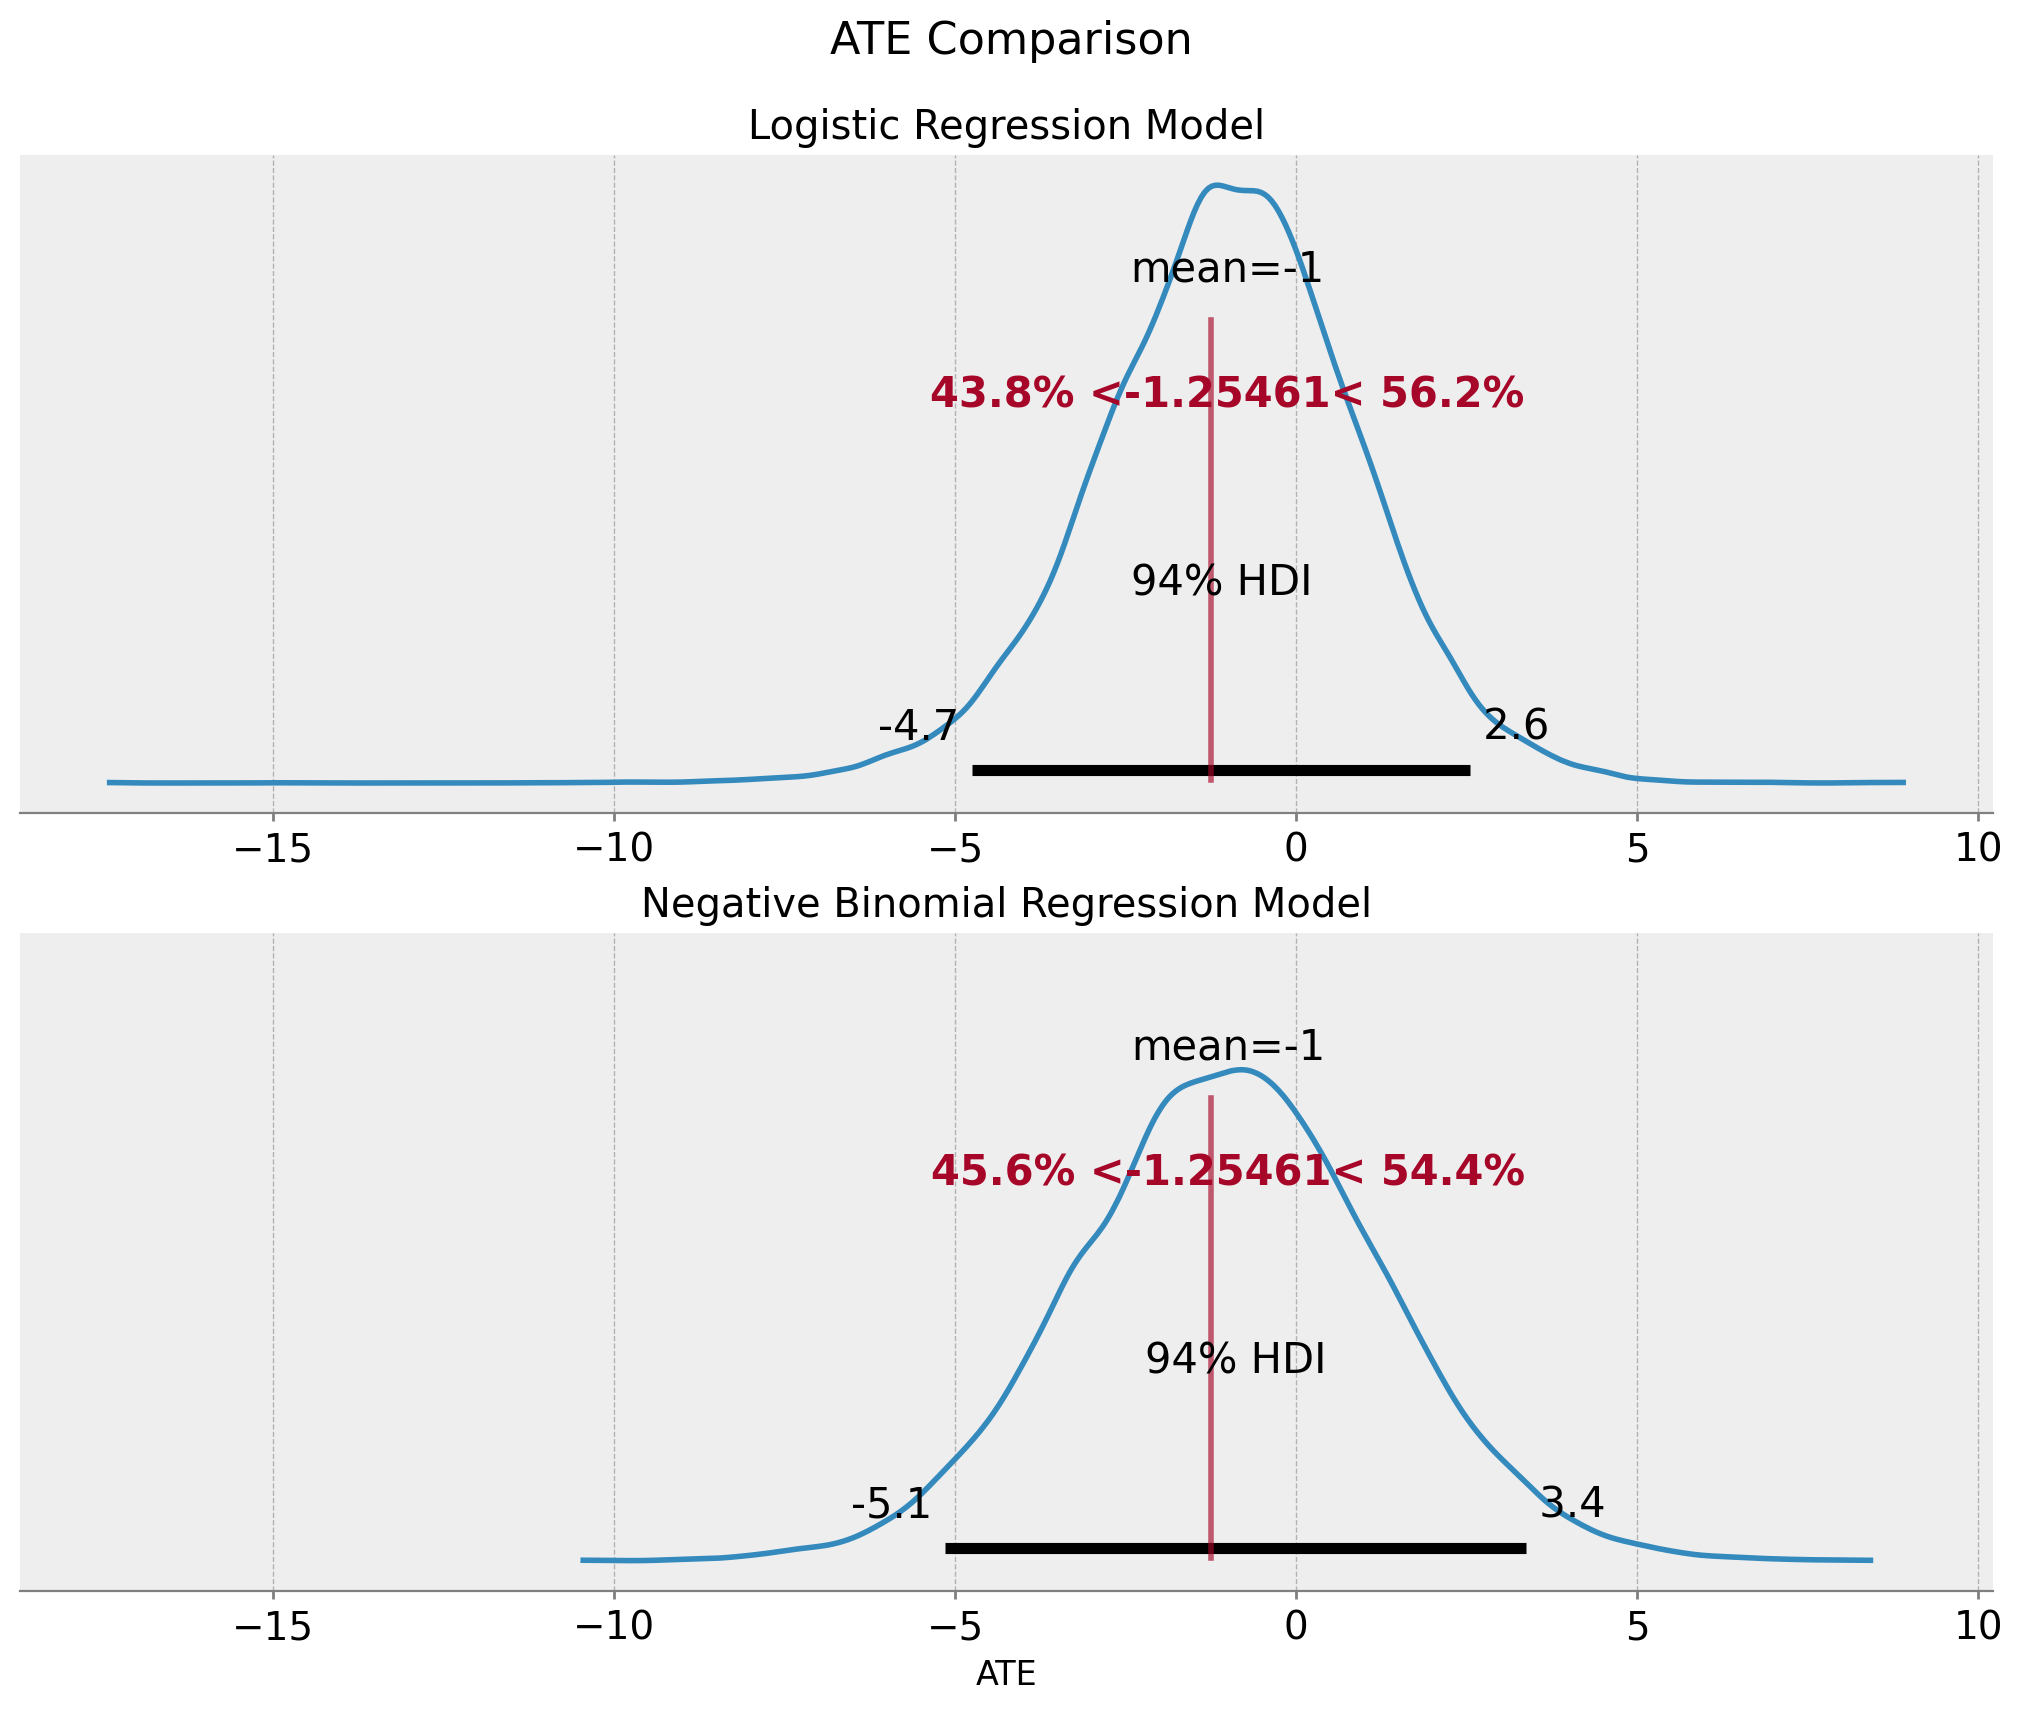

In [23]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 8), layout="constrained"
)
az.plot_posterior(data=ate_samples, ref_val=diff_means, ax=ax[0])
ax[0].set(title="Logistic Regression Model")
az.plot_posterior(data=gaussian_idata, var_names=["trt"], ref_val=diff_means, ax=ax[1])
ax[1].set(title="Negative Binomial Regression Model", xlabel="ATE")
fig.suptitle("ATE Comparison", y=1.05, fontsize=16)


The resulting ATE posterior distributions are very similar. Note however that the posterior means does not match the sample ATE computed from the difference in means. Still, in view of the posterior distribution uncertainty it looks compatible.

Which model to choose? As discussed in the previous post, conceptually the negative binomial model seems is more appropriate. Moreover, by running some experiment I saw that the linear regression model is very sensitive to the prior specification of the group variable `trt`. It is actually easier to reason about the priors in the negative binomial model as one is really trying to model the underlying distribution. This is yet another reason to prefer the negative binomial model.

Text(0.5, 1.05, 'Posterior Predictive Check')

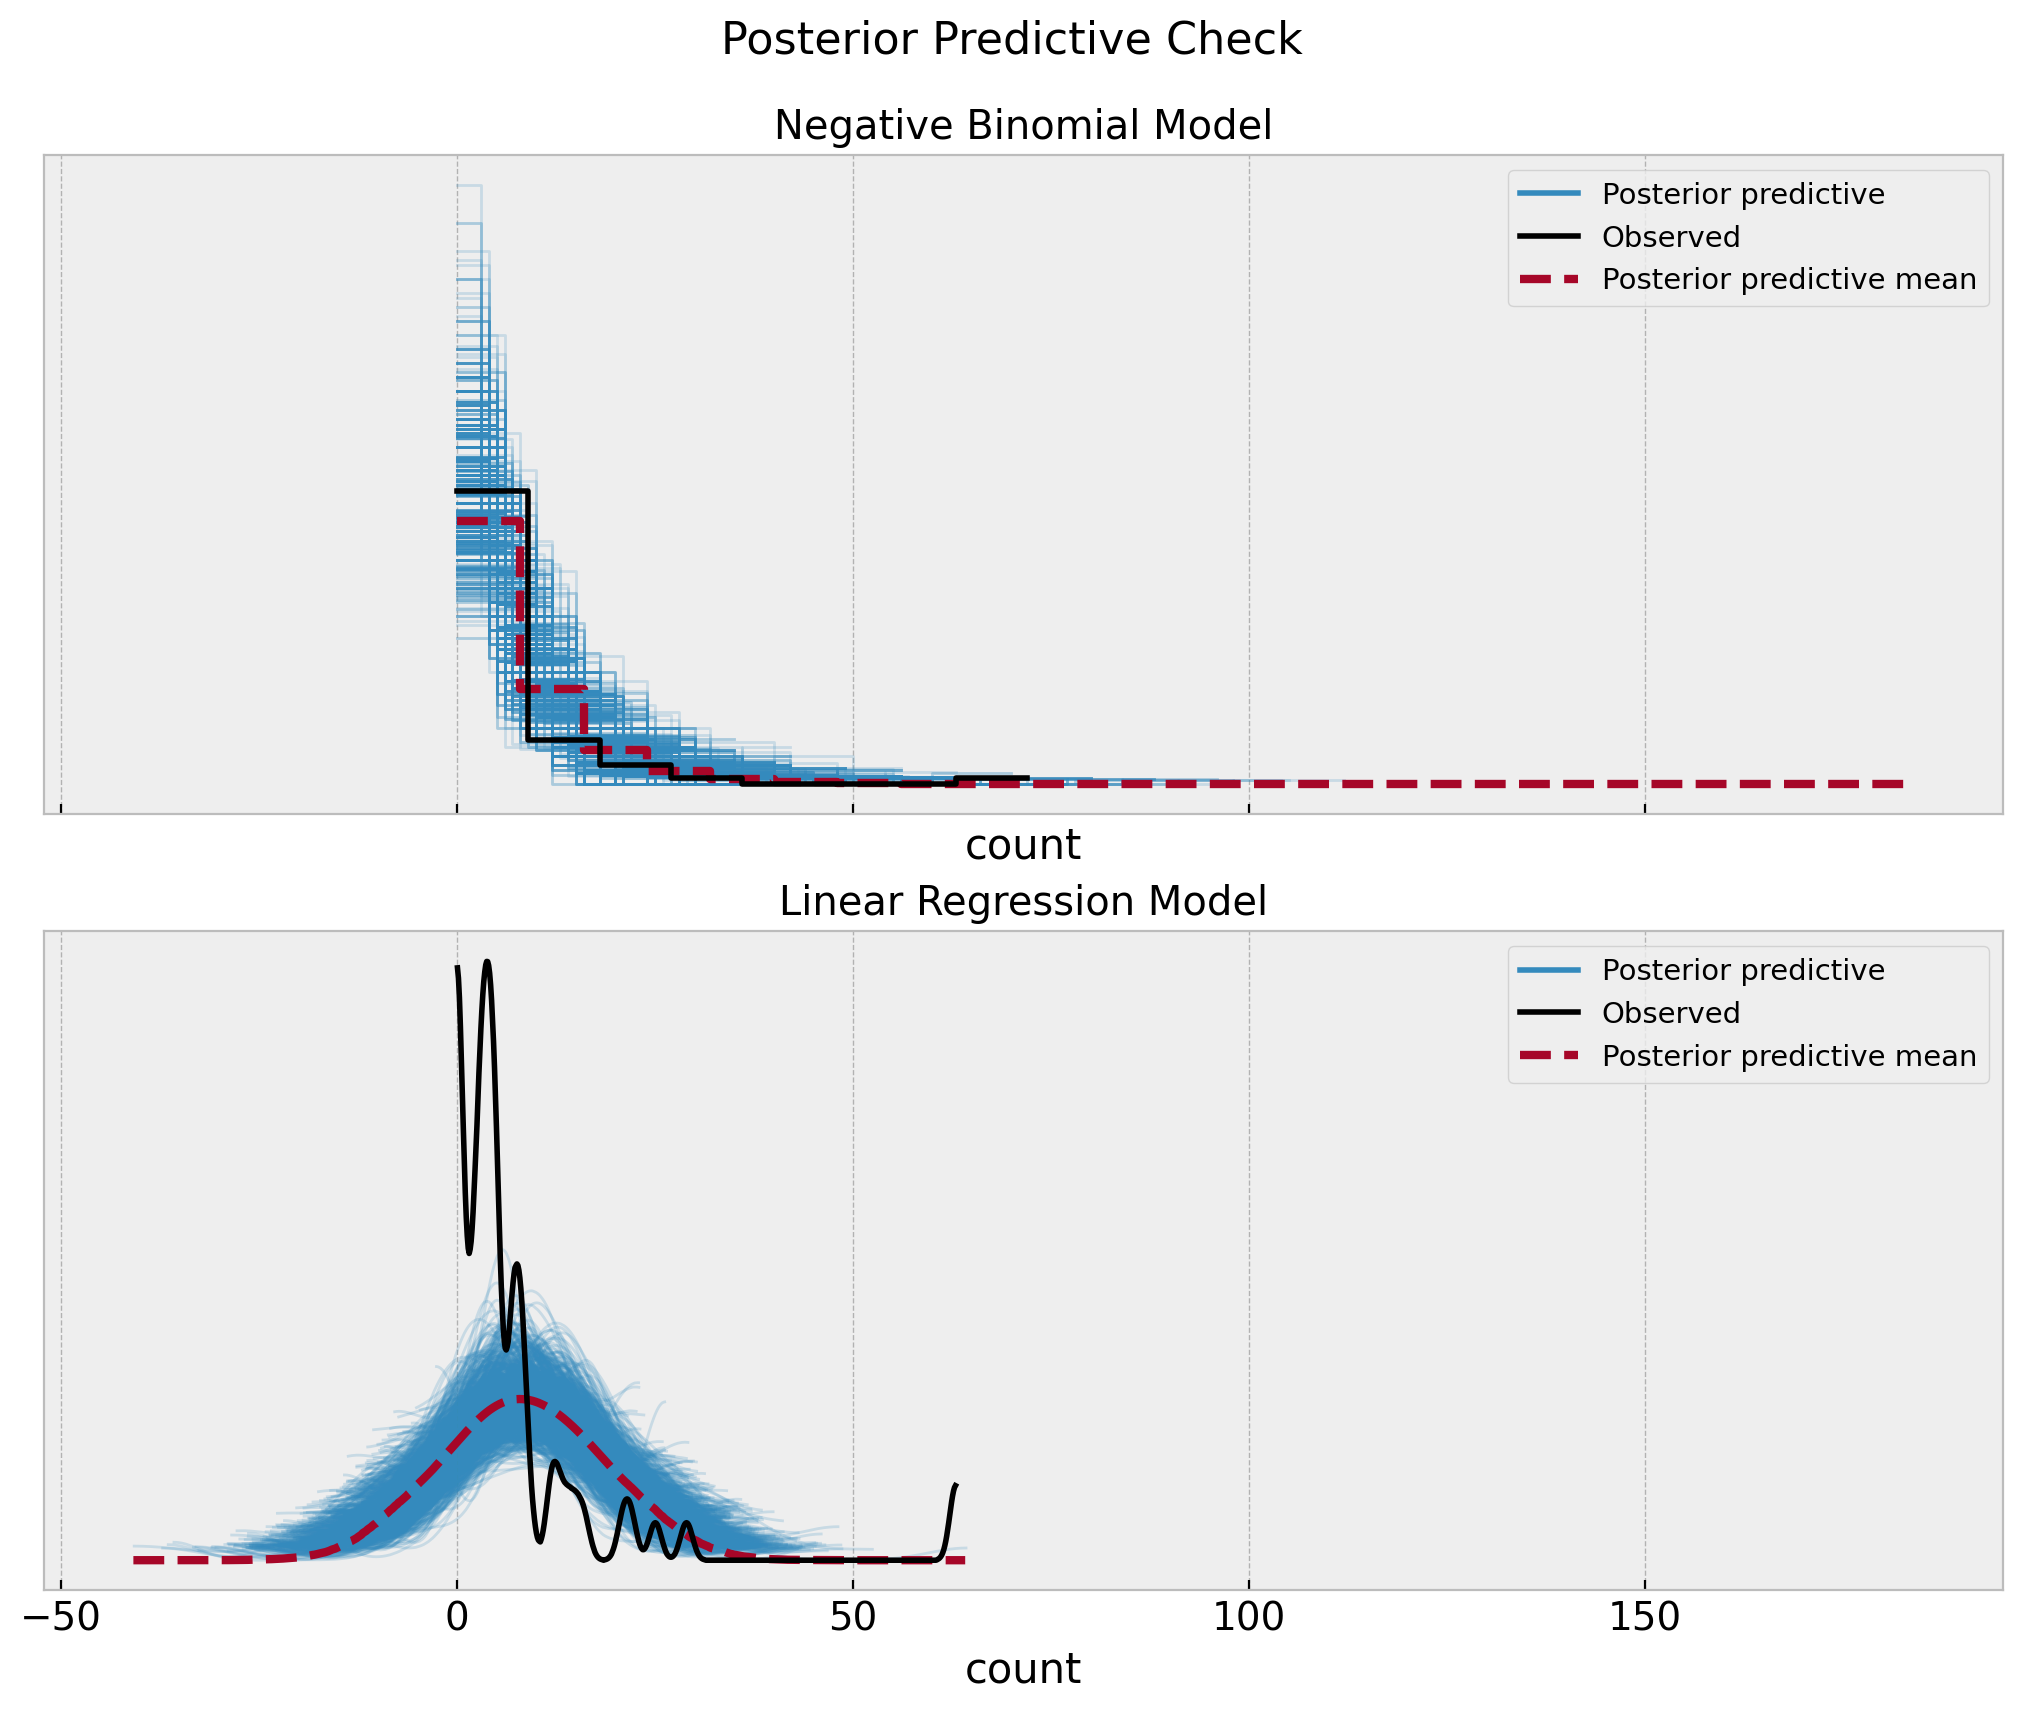

In [24]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=False, figsize=(10, 8), layout="constrained"
)
az.plot_ppc(data=negative_binomial_idata, num_pp_samples=1_000, ax=ax[0])
ax[0].set(title="Negative Binomial Model", xlabel="count")
az.plot_ppc(data=gaussian_idata, num_pp_samples=1_000, ax=ax[1])
ax[1].set(title="Linear Regression Model", xlabel="count")
fig.suptitle("Posterior Predictive Check", y=1.05, fontsize=16)
